<a href="https://colab.research.google.com/github/andrehochuli/teaching/blob/main/AprendizadoMaquina/T%C3%B3pico%2004%20-%20Deep%20Learning%20/T%C3%B3pico_04_Deep_Learning_Redes_Neurais_Recorrentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Redes Neurais Recorrentes

Neste notebook iremos abordar de forma técnica a implementação de uma Rede Neural Recorrente (RNN). A RNN é uma arquitetura de aprendizado profundo que se destaca na modelagem de sequências e dados temporais. Sua capacidade de capturar dependências de longo prazo a torna ideal para tarefas como processamento de linguagem natural, tradução automática, análise de sentimentos e previsão de séries temporais.

Também abordaremos as variantes da RNN, como a LSTM (Long Short-Term Memory) que foram desenvolvidas para superar o desafio do gradiente que desaparece ou explode.

Para a implementação utilizaremos a TensorFlow e uma base climática como exemplo.

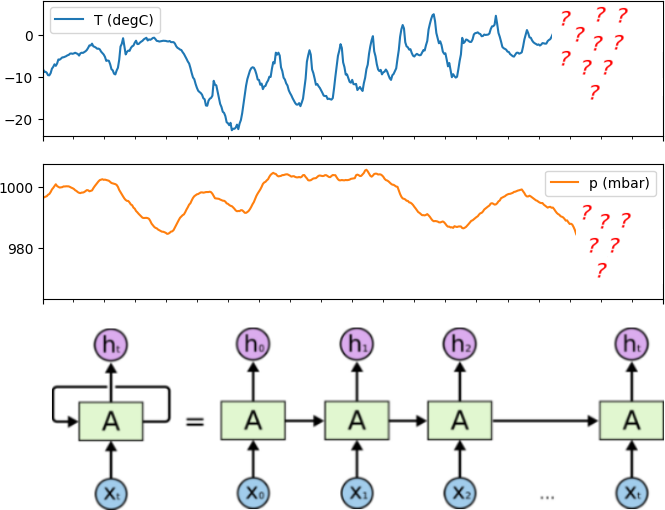


In [31]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


#Dataset - Dados Climáticos 
* [[link]](https://www.bgc-jena.mpg.de/wetter/)
* 14 caracteristicas (temp, pressão, umididade, etc). 

* Granularidade: 10 minutos desde 2003

* Utilizaremos a fração de 2009 até 2016. 

* Objetivo: Determinar uma temperatura no futuro utilizando diversos parâmetros.

In [32]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [33]:
df = pd.read_csv(csv_path)

In [34]:
df.head(-20)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420526,31.12.2016 20:00:00,1001.47,-1.52,271.52,-7.13,65.42,5.46,3.57,1.89,2.22,3.57,1282.60,1.24,1.96,232.0
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420528,31.12.2016 20:20:00,1001.42,-2.15,270.90,-7.08,68.77,5.21,3.59,1.63,2.23,3.58,1285.50,0.79,1.24,184.3
420529,31.12.2016 20:30:00,1001.45,-3.19,269.86,-7.15,73.90,4.83,3.57,1.26,2.22,3.56,1290.48,1.19,1.84,190.0


# Parte 1: Previsão univalorada


Primeiro vamos criar um modelo utilizando apenas uma *feature* (temperatura). Abaixo extraimos apenas a informação de temperatura do dataset.

In [35]:
data = df['T (degC)']

data.index = df['Date Time']

print ("Numero de Amostras: ", len(data))
print ("Vetor de valores:" , data.values)
data.head()


Numero de Amostras:  420551
Vetor de valores: [-8.02 -8.41 -8.51 ... -3.16 -4.23 -4.82]


Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

Abaixo plotamos o gráfico de variação da temperatura desde 2009 a 2016

array([<Axes: xlabel='Date Time'>], dtype=object)

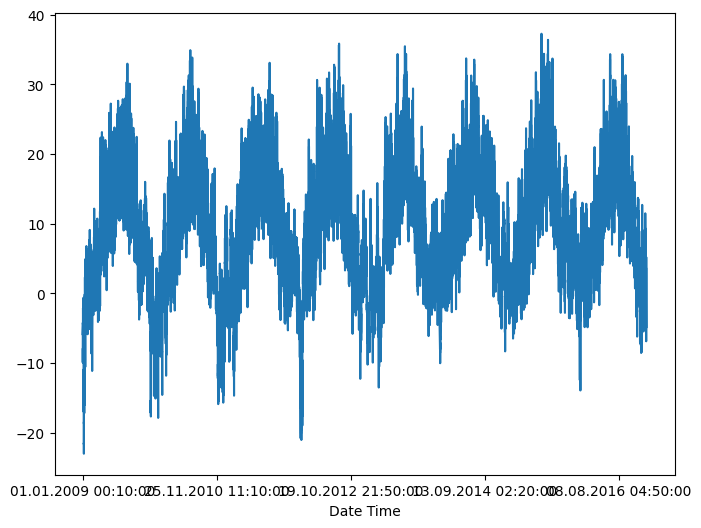

In [36]:
data.plot(subplots=True)

In [37]:
TRAIN_SPLIT = 300000 #300 mil observações para treino
tf.random.set_seed(13)

uni_data = data.values

#Criação dos Datasets de Treinamento e Validação

* A função abaixo retorna a fração do dataset a ser utilizada sendo:

          * history_size: janela a ser observada
          * target_size: O exato momento a ser avaliado 


In [38]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    #if i < 1000: print(indices)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

Exemplo para a base de treinamento: univariate_data(dataset, 0, 300000, 50, 5), considerando janela histórica de tamanho 50 e rótulo 5 observações a frente.

start_index = 0

end_index = 300000

history_size = 50 (observações)

target_size = 5 (steps)

dataset = [t0, t1, ...., t300000]

treino = [[t0, .., t49],[t54], [t1, .., t50],[t55], [t2, .., t51],[t56] ...]

shape do treino = 299950 sequências de tamanho (50) + rótulo tamanho (1)


In [39]:
'''Tamanho da Janela do Historico'''
univariate_past_history = 50  #50 observacoes anteriores
future = univariate_future_target = 5  # prever 5 observações a frente 

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)


In [40]:
print(x_train_uni.shape)
print(x_train_uni[0],y_train_uni[0])

(299950, 50, 1)
[[-8.02]
 [-8.41]
 [-8.51]
 [-8.31]
 [-8.27]
 [-8.05]
 [-7.62]
 [-7.62]
 [-7.91]
 [-8.43]
 [-8.76]
 [-8.88]
 [-8.85]
 [-8.83]
 [-8.66]
 [-8.66]
 [-8.7 ]
 [-8.81]
 [-8.84]
 [-8.94]
 [-8.94]
 [-8.86]
 [-8.99]
 [-9.05]
 [-9.23]
 [-9.49]
 [-9.5 ]
 [-9.35]
 [-9.47]
 [-9.63]
 [-9.67]
 [-9.68]
 [-9.9 ]
 [-9.91]
 [-9.51]
 [-9.67]
 [-9.59]
 [-9.15]
 [-8.91]
 [-9.04]
 [-9.43]
 [-9.17]
 [-8.71]
 [-8.55]
 [-8.4 ]
 [-8.3 ]
 [-8.13]
 [-8.1 ]
 [-8.14]
 [-8.06]] -7.56


Para efeito de visualização, vamos analisar as janelas de observações criadas e sua respectiva temperatura (label)

#Amostras: 299950 #Labels:  299950
Amostra[0]:
 [[-3.87]
 [-3.78]
 [-3.77]
 [-3.95]
 [-3.9 ]
 [-3.75]
 [-3.81]
 [-3.84]
 [-3.88]
 [-3.67]
 [-3.3 ]
 [-3.34]
 [-3.24]
 [-3.15]
 [-3.07]
 [-2.93]
 [-2.78]
 [-2.76]
 [-2.76]
 [-2.76]
 [-2.71]
 [-2.67]
 [-2.69]
 [-2.7 ]
 [-2.64]
 [-2.58]
 [-2.46]
 [-2.33]
 [-2.12]
 [-1.97]
 [-1.9 ]
 [-1.9 ]
 [-1.83]
 [-1.7 ]
 [-1.6 ]
 [-1.55]
 [-1.46]
 [-1.42]
 [-1.49]
 [-2.01]
 [-2.32]
 [-2.37]
 [-2.32]
 [-2.22]
 [-2.09]
 [-2.04]
 [-2.25]
 [-2.54]
 [-2.26]
 [-2.2 ]] 
Temperatura:  -1.88


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

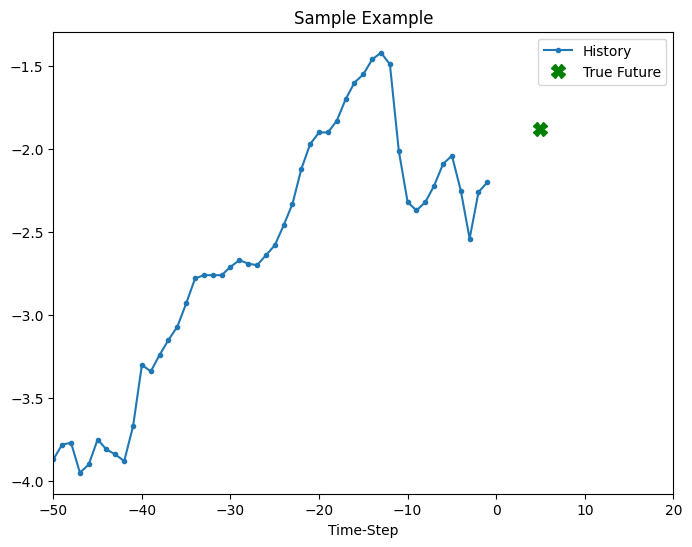

In [41]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'gX', 'ro']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
      future = delta
    else:
      future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
      if i:
        plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
      else:
        plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

sample_id = 400
print("#Amostras:", len(x_train_uni),"#Labels: ", len(y_train_uni))
print ("Amostra[0]:\n", x_train_uni[sample_id],"\nTemperatura: ", y_train_uni[sample_id])
show_plot([x_train_uni[sample_id], y_train_uni[sample_id]], future, 'Sample Example')

#Modelo Baseline (Média)
Para efeitos comparativos, vamos criar um modelo de predição utilizando a média das últimas 20 observações. Este simples modelo nos revela como a média pode ser falha para prever séries temporais

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

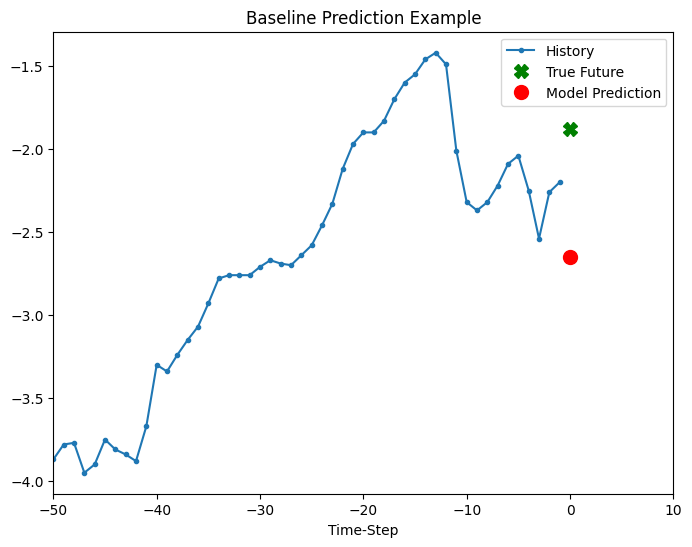

In [42]:
def baseline(history):
  return np.mean(history)

show_plot([x_train_uni[sample_id], y_train_uni[sample_id], baseline(x_train_uni[sample_id])], 0,
           'Baseline Prediction Example')

# Recurrent neural network (SimpleRNN and LSTM)

##Provedores de Dados da TF

In [43]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

##Criando as arquiteturas

###RNN

In [44]:
print(x_train_uni.shape[1])
print(x_train_uni.shape[2])
simple_rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(16, return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])),    
    tf.keras.layers.SimpleRNN(8),
    tf.keras.layers.Dense(1)
])


simple_rnn_model.compile(optimizer='adam', loss='mae')

simple_rnn_model.summary()



50
1
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50, 16)            288       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 8)                 200       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


###LSTM


In [45]:

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')


simple_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 16)            1152      
                                                                 
 lstm_3 (LSTM)               (None, 8)                 800       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,961
Trainable params: 1,961
Non-trainable params: 0
_________________________________________________________________


## Treinamento

Cada epoca conterá apenas 200 steps (lotes) ao invés da base toda. Podemos alterar este número depois para ver o impacto.

In [46]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

###RNN

In [47]:
from tensorflow.keras.callbacks import EarlyStopping

#Se não houver melhoria apos 3 epocas, para o treinamento
es=EarlyStopping(monitor='val_loss', verbose=1, patience=3)

rnn_log = simple_rnn_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50, callbacks=[es])

Epoch 1/10
200/200 [==============================] - 25s 113ms/step - loss: 7.7543 - val_loss: 4.0970
Epoch 2/10
200/200 [==============================] - 30s 151ms/step - loss: 5.1807 - val_loss: 3.0339
Epoch 3/10
200/200 [==============================] - 28s 140ms/step - loss: 4.4415 - val_loss: 2.3773
Epoch 4/10
200/200 [==============================] - 22s 110ms/step - loss: 4.0811 - val_loss: 1.8008
Epoch 5/10
200/200 [==============================] - 22s 112ms/step - loss: 3.0403 - val_loss: 1.4583
Epoch 6/10
200/200 [==============================] - 22s 110ms/step - loss: 2.6401 - val_loss: 1.1896
Epoch 7/10
200/200 [==============================] - 21s 105ms/step - loss: 2.0086 - val_loss: 0.9877
Epoch 8/10
200/200 [==============================] - 22s 111ms/step - loss: 1.7749 - val_loss: 0.8443
Epoch 9/10
200/200 [==============================] - 22s 110ms/step - loss: 1.6066 - val_loss: 0.7085
Epoch 10/10
200/200 [==============================] - 21s 103ms/step - l

###LSTM

In [48]:
lstm_log = simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50, callbacks=[es])

Epoch 1/10
200/200 [==============================] - 6s 13ms/step - loss: 7.8638 - val_loss: 4.6639
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 5.9905 - val_loss: 3.4609
Epoch 3/10
200/200 [==============================] - 2s 11ms/step - loss: 4.9385 - val_loss: 2.6640
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 4.4880 - val_loss: 2.0434
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 3.3252 - val_loss: 1.6177
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 2.8932 - val_loss: 1.2804
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 2.1893 - val_loss: 1.0407
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 1.8799 - val_loss: 0.8815
Epoch 9/10
200/200 [==============================] - 2s 11ms/step - loss: 1.7007 - val_loss: 0.7585
Epoch 10/10
200/200 [==============================] - 2s 10ms/step - loss: 1.6999 - val_los

##Visualização do Treinamento

In [49]:
simple_lstm_model.save('model')

jsmodel=simple_lstm_model.to_json()
with open('model_config.json', 'w') as json_file:
    json_file.write(jsmodel)

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

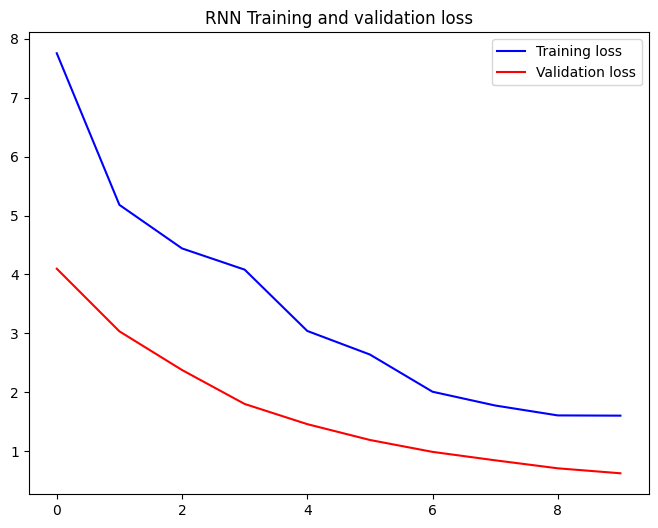

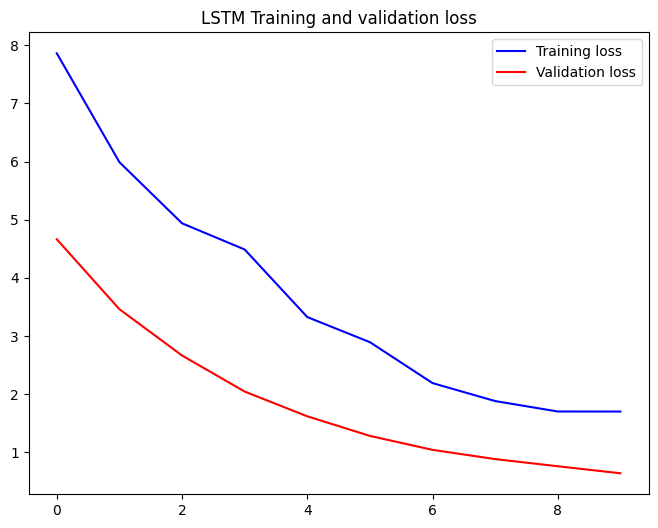

In [50]:
 plot_train_history(rnn_log,
                   'RNN Training and validation loss')
 plot_train_history(lstm_log,
                   'LSTM Training and validation loss')

8/8 [==============================] - 1s 4ms/step


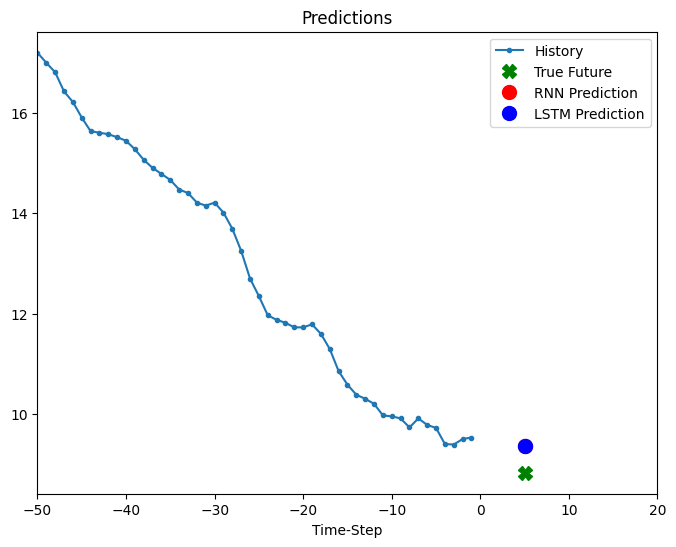

8/8 [==============================] - 0s 4ms/step


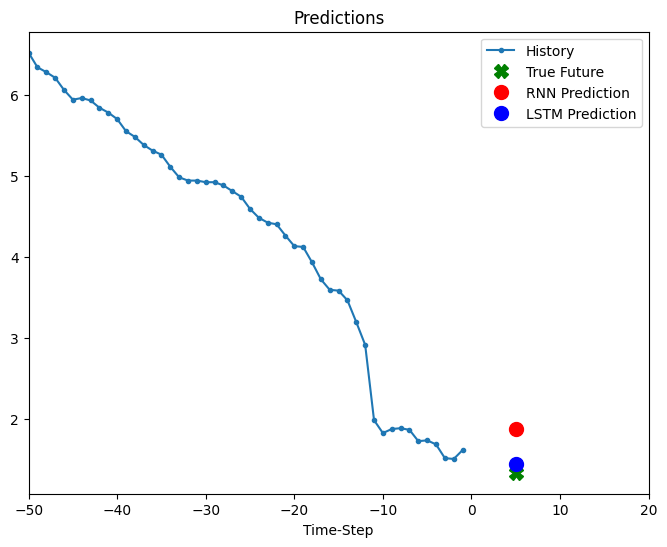

8/8 [==============================] - 0s 4ms/step


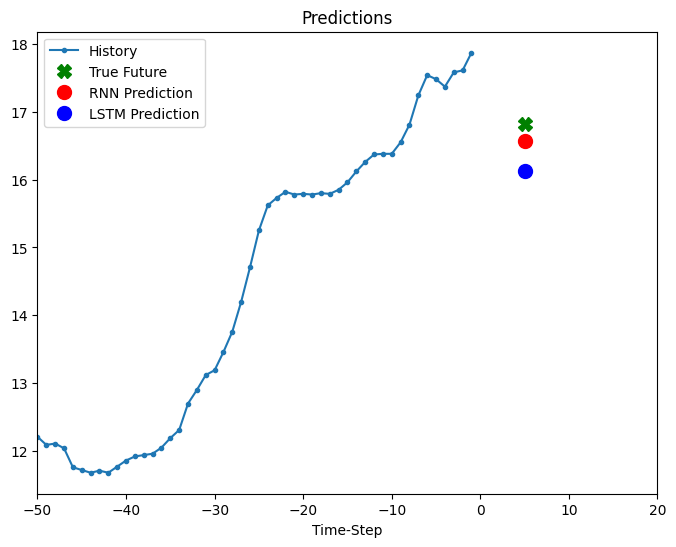

8/8 [==============================] - 0s 4ms/step


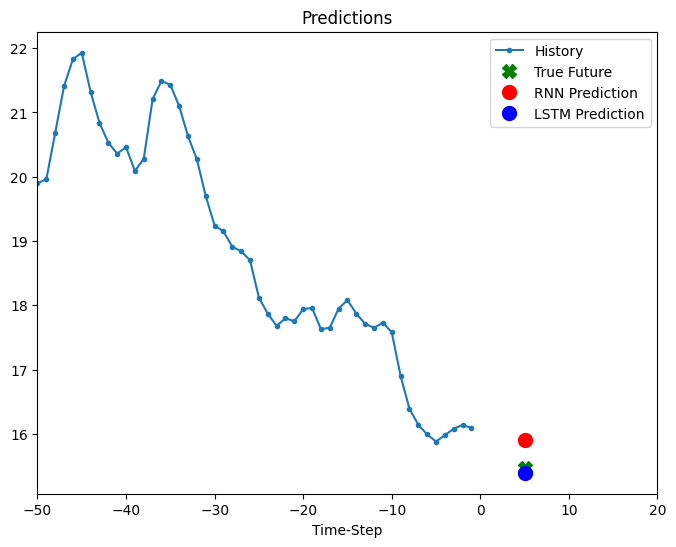

8/8 [==============================] - 0s 4ms/step


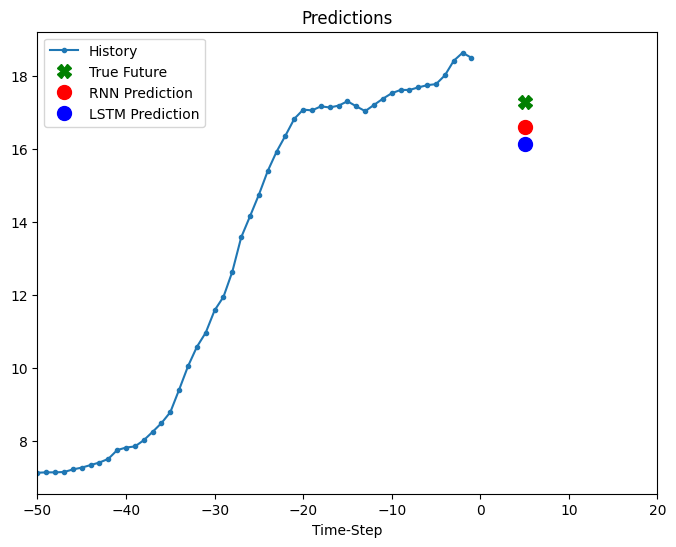

8/8 [==============================] - 0s 6ms/step


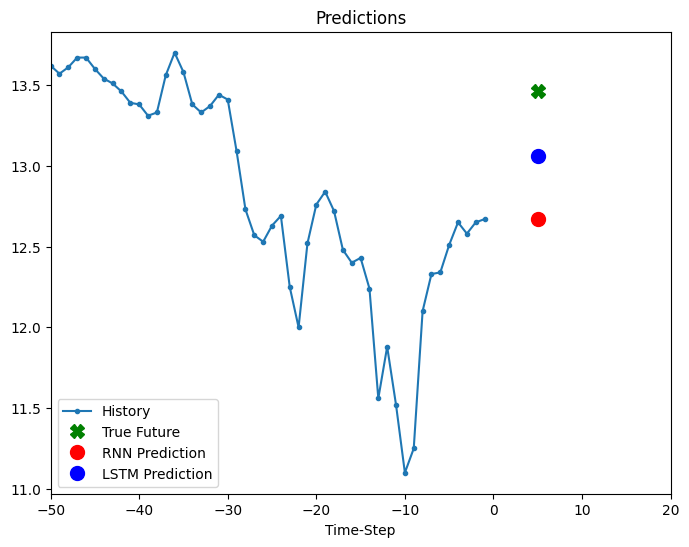

8/8 [==============================] - 0s 5ms/step


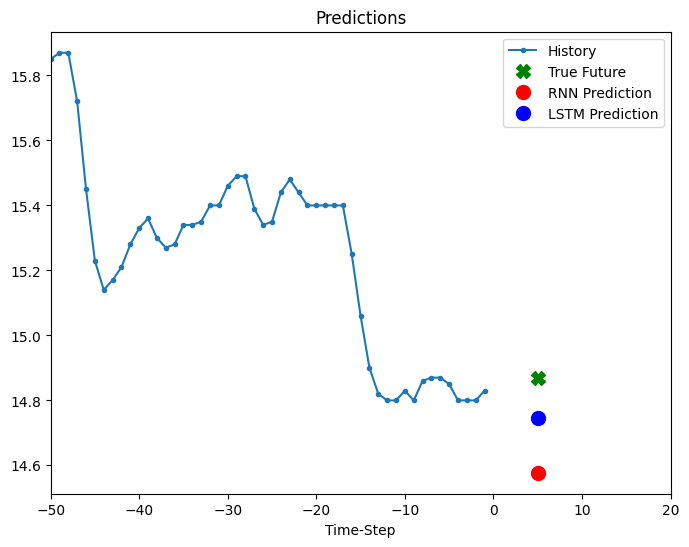

8/8 [==============================] - 0s 5ms/step


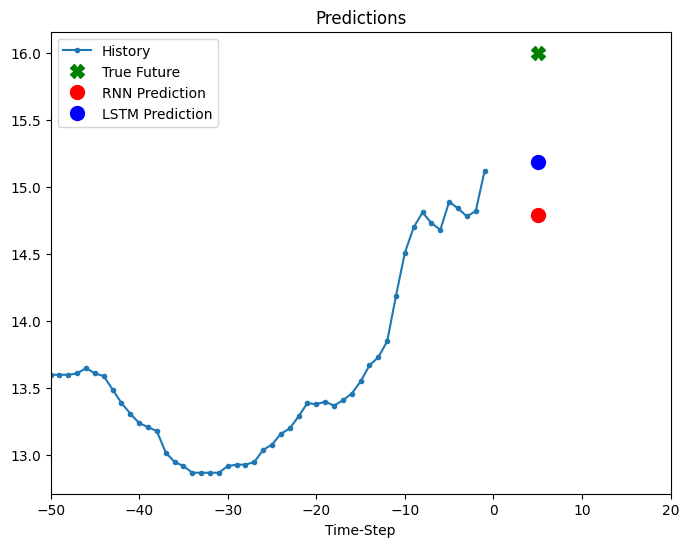

8/8 [==============================] - 0s 5ms/step


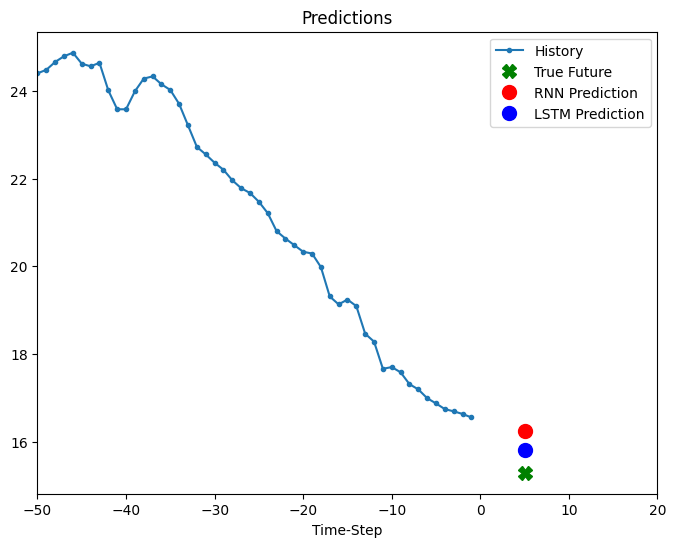

8/8 [==============================] - 0s 4ms/step


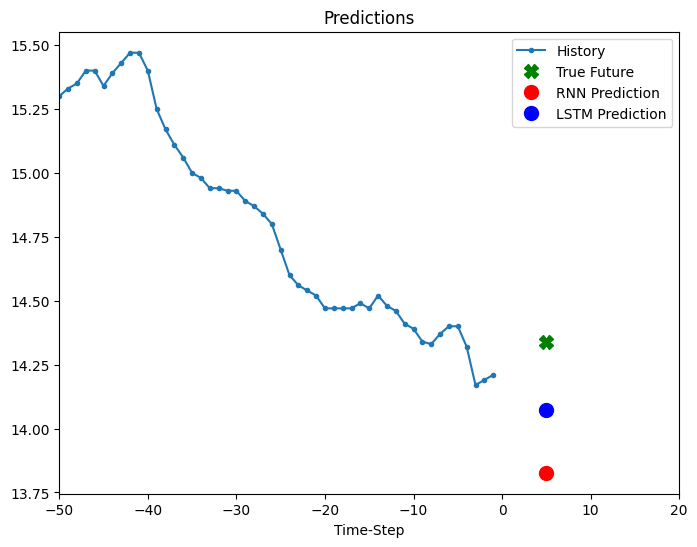

8/8 [==============================] - 0s 12ms/step
[9.377335]
<_TakeDataset element_spec=(TensorSpec(shape=(None, 50, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [51]:
def plot_preds(plot_data, delta=0):
    labels = ['History', 'True Future', 'RNN Prediction','LSTM Prediction']
    marker = ['.-', 'gX', 'ro' , 'bo']
    time_steps = create_time_steps(plot_data[0].shape[0])
    

    future = delta

    plt.title('Predictions')
    for i, x in enumerate(plot_data):
      if i:
        plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
      else:
        plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

for x, y in val_univariate.take(1):
  for sample in range(10):
    plot = plot_preds([x[sample].numpy(), y[sample].numpy(),
                    simple_rnn_model.predict(x)[sample], simple_lstm_model.predict(x)[sample]], future)
    plot.show()

print(simple_rnn_model.predict(x)[0])
print(val_univariate.take(1))

##Erro médio Quadrático

In [52]:
#erro médio quadratico

y_true = []
y_pred_rnn = []
y_pred_lstm = []


for x_test, y_test in val_univariate.take(10):
  
  y_true.append(y_test)
  y_pred_rnn.append(simple_rnn_model.predict(x_test,verbose=0))
  y_pred_lstm.append(simple_lstm_model.predict(x_test,verbose=0))


   

y_true = np.array(y_true).flatten()
y_pred_rnn = np.array(y_pred_rnn).flatten()
y_pred_lstm = np.array(y_pred_lstm).flatten()

print(y_true.shape)


mse_rnn = np.sqrt(np.square(y_true - y_pred_rnn).mean())
mse_lstm = np.sqrt(np.square(y_true - y_pred_lstm).mean())

  
print(mse_rnn, mse_lstm)
  

(2560,)
1.3253566666009846 1.428789648499609


#Exercícios

Para o melhor entendimento, algumas questões devem ser avaliadas!

* Se treinar por mais épocas e mais instâncias, aumenta a performance da rede? 

* A rede se comporta melhor para prever 1, 3, 5 ou 10 observações à frente?

* Se alterar o tamanho da janela de histórico, qual deve ser impacto? 

* Calcule uma taxa de acerto (use todas amostras de validação)

Existe alguma relação entre o tamanho da janela de histórico com o número de 'steps' que desejamos prever a frente?

Na sua opinião, a temperatura por si só, é eficiente como único dado para sua própria predição?
